### LangGraph

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langchain_community.tools import TavilySearchResults
import operator


load_dotenv()

True

In [2]:
loader = DirectoryLoader(path='data', glob='./*.pdf', loader_cls=PyPDFLoader)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
split_text = splitter.split_documents(documents=docs)

embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-small-en')

vectorstore = Chroma.from_documents(split_text, embeddings)

vectorstore.add_documents(documents=split_text)

retriever = vectorstore.as_retriever()

model = ChatGroq(model='gemma2-9b-it')

In [3]:
class State(TypedDict):
    query: str
    retry_counter: int = 0
    messages: Annotated[Sequence[BaseMessage], operator.add]
    source: Annotated[Sequence[BaseMessage], operator.add]
    validation_score: Annotated[Sequence[BaseMessage], operator.add]

In [4]:
class TopicSelectionParser(BaseModel):
    topic: str = Field(description='Selected topic')
    reasoning: str = Field(description='Reasoning behind topic selection')
    
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [5]:
def supervisor(state: State) -> State:
    print('-- Supervisor --')
    retry_counter = state['retry_counter']
    retry_counter += 1
    state['retry_counter'] = retry_counter
    
    query = state['query']
    template = '''
    Your task is to classify the given user query to one of the following categories: [Finance, GDP, Unrelated].
    Only respond with the category name and nothing else.
    
    User query: {query}
    {format_instructions}
    '''
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['query'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )
    
    chain = prompt | model | parser
    
    response = chain.invoke({'query': query})
    
    # print(f'Parsed response: {response}')
    
    state['messages'] = [response.topic]
    state['source'] = ['SUPERVISOR']
    
    return state
    

In [6]:
def router(state: State):
    print('-- Router --')
    message = state['messages'][-1]
    source = state['source'][-1]
    # print(f'Recent message: {message} from source: {source}')
    if 'finance' in message.lower():
        return 'llm'
    elif 'gdp' in message.lower():
        return 'rag'
    return 'web_search'

In [7]:
def llm(state: State) -> State:
    print('-- LLM --')
    query = state['query']
    prompt = f'You are an expert in explaining financial terms. Answer the following question to the best of your ability. Do not stray from the financial world. If you don\'t know the answer, just say \'NA\', do not make up any answer. The question is {query}'
    
    response = model.invoke(prompt)
    # print(f'Response: {response}')
    state['messages'] = [response.content]
    state['source'] = ['LLM']
    
    return state

In [8]:
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

In [9]:
def rag(state: State) -> State:
    print('-- RAG --')
    query = state['query']
    
    prompt = PromptTemplate(
        template='''
        You are an assistant for question-answer task. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say 'NA', don't make up any answer. Use three sentences maximum and keep the answer concise.\n Question: {question} \nContext: {context} \nAnswer:
        ''',
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {'context': retriever | format_docs, 'question': RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    
    response = rag_chain.invoke(query)
    # print(f'Response from RAG: {response}')
    
    state['messages'] = [response]
    state['source'] = ['RAG']
    return state

In [10]:
tavily_search = TavilySearchResults(
    max_results=3,
    search_depth='basic',
    include_images=False
)

In [11]:
def web_search(state: State):
    print('-- WEB --')
    query = state['query']
    response = tavily_search.run(query)
    # print(f'Response: {response}')
    state['messages'] = [response[0]['content']]
    state['source'] = ['WEB']
    
    return state

In [12]:
def validate(state: State) -> State:
    print('-- VALIDATOR --')
    query = state['query']
    message = state['messages'][-1]
    template = f'You are given a question and an answer. Your task is to give a confidence score based on the relationship between them. If they are completely unrelated return 0.0 and if they are aligned return 1.0. If they are related provide a number between 0 and 1 with a single precision decimal. Return only the score and nothing else. \nQuestion: {query} \nAnswer: {message}'
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['query', 'answer']
    )
    
    chain = prompt | model | StrOutputParser()
    
    response = chain.invoke({'query': query, 'answer': message})
    # print(f'Response: {response}')
    state['validation_score'] = [float(str(response).strip())]
    state['source'] = ['VALIDATOR']
    
    return state
    

In [13]:
def route_validator(state: State):
    score = state['validation_score'][-1]
    if score >= 0.7 or state['retry_counter'] == 3:
        return END
    return 'supervisor'
    

In [14]:
workflow = StateGraph(State)

workflow.add_node('supervisor', supervisor)
workflow.add_node('llm', llm)
workflow.add_node('rag', rag)
workflow.add_node('web_search', web_search)
workflow.add_node('validator', validate)

workflow.set_entry_point('supervisor')

workflow.add_conditional_edges(
    'supervisor',
    router,
    ['llm', 'rag', 'web_search']
)

workflow.add_edge('llm', 'validator')
workflow.add_edge('rag', 'validator')
workflow.add_edge('web_search', 'validator')

workflow.add_conditional_edges(
    'validator', 
    route_validator,
    ['supervisor', END]
)

graph = workflow.compile()

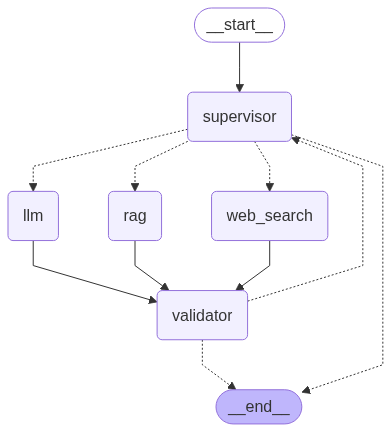

In [15]:
img_bytes = graph.get_graph().draw_mermaid_png()
with open('workflow.png', 'wb') as f:
    f.write(img_bytes)
display(Image(img_bytes))

In [16]:
def display_result(result):
    print(f'Message: {result['messages'][-1]} \nScore: {result['validation_score'][-1]}')

In [17]:
state = {
    'query': 'Compare Germany and China\'s GDP',
    'messages': [],
    'source': [],
    'retry_counter': 0
}

result = graph.invoke(state)
display_result(result)

-- Supervisor --
-- Router --
-- RAG --
-- VALIDATOR --
Message: China's GDP is significantly larger than Germany's.  China's 2023 nominal GDP is estimated to be between $17.8 and $18.4 trillion, while Germany's is $4.526 trillion.  The difference in GDP reflects the size and economic output of each country. 
 
Score: 1.0


In [18]:
state = {
    'query': 'What does George do with the US dollars?',
    'messages': [],
    'source': [],
    'retry_counter': 0
}

result = graph.invoke(state)
display_result(result)

-- Supervisor --
-- Router --
-- WEB --
-- VALIDATOR --
-- Supervisor --
-- Router --
-- WEB --
-- VALIDATOR --
-- Supervisor --
-- Router --
-- WEB --
-- VALIDATOR --
Message: It was in 1869 that George Washington's face first appeared on the one dollar bill. The design of the dollar changed quite a bit up until 1963 when the bill we recognize today was first created. Unlike most of the rest of our paper money, the one dollar bill has not been redesigned since then and there are no plans to do so. 
Score: 0.0
